In [1]:
import ingestor, modeller, fitter
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.style.use('seaborn-notebook')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['figure.figsize'] = [15, 10]

In [3]:
from importlib import reload

reload(fitter)
reload(modeller)
reload(ingestor)

<module 'ingestor' from '/media/dwu402/Data/wrap-mad/ingestor.py'>

In [4]:
context = ingestor.initialise_context()
ingestor.read_run_file(context, "runs/minimal4.3.run")

In [5]:
model = modeller.Model(context)

In [6]:
solver = fitter.Fitter()
solver.construct_objectives(context, model)

In [7]:
solver.construct_problems()

In [8]:
for rhoi in np.logspace(-10, 5, num=97):
    solver.solve(rhoi)
    solver.problems[0].initial_guess = solver.solutions[str(rhoi)][-1].x

In [9]:
solver.solutions

{'1e-10': [      fun: 0.08288483785017405
   hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
        jac: array([-4.68959845e-17,  4.86060086e-17, -1.25291932e-17,  3.66035974e-17,
          1.90431030e-16, -9.37048811e-16, -5.25416195e-16, -6.25296758e-16,
          7.96220443e-16,  2.09910292e-17, -7.78821038e-16])
    message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
       nfev: 1
        nit: 0
     status: 0
    success: True
          x: array([3.e-01, 1.e+00, 7.e-01, 1.e+00, 2.e+00, 1.e+00, 1.e+00, 1.e+00,
         1.e+00, 1.e+00, 1.e-03])],
 '1.4330125702369628e-10': [      fun: 0.08288483785017405
   hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
        jac: array([-6.72025353e-17,  6.96530214e-17, -1.79544914e-17,  5.24534152e-17,
          2.72890059e-16, -1.34280273e-15, -7.52928012e-16, -8.96058115e-16,
          1.14099390e-15,  3.00804088e-17, -1.11606034e-15])
    message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
       nfev: 1

Text(0.5, 0, '$\\rho$, Model Weighting Parameter')

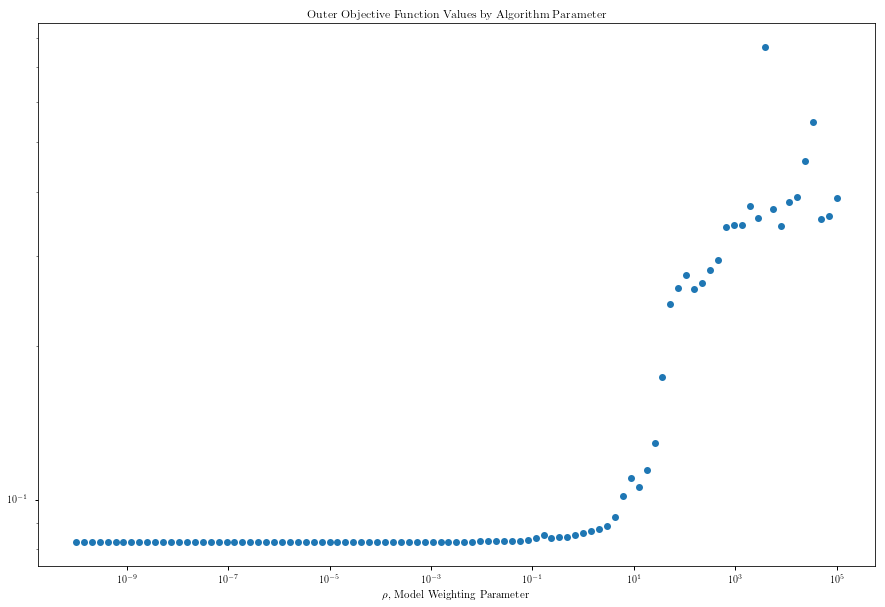

In [10]:
outer_objective_values = np.array([[float(rho), val[0].fun] for rho, val in solver.solutions.items()])
plt.loglog(*outer_objective_values.T, 'o')
plt.title("Outer Objective Function Values by Algorithm Parameter")
plt.xlabel(r"$\rho$, Model Weighting Parameter")

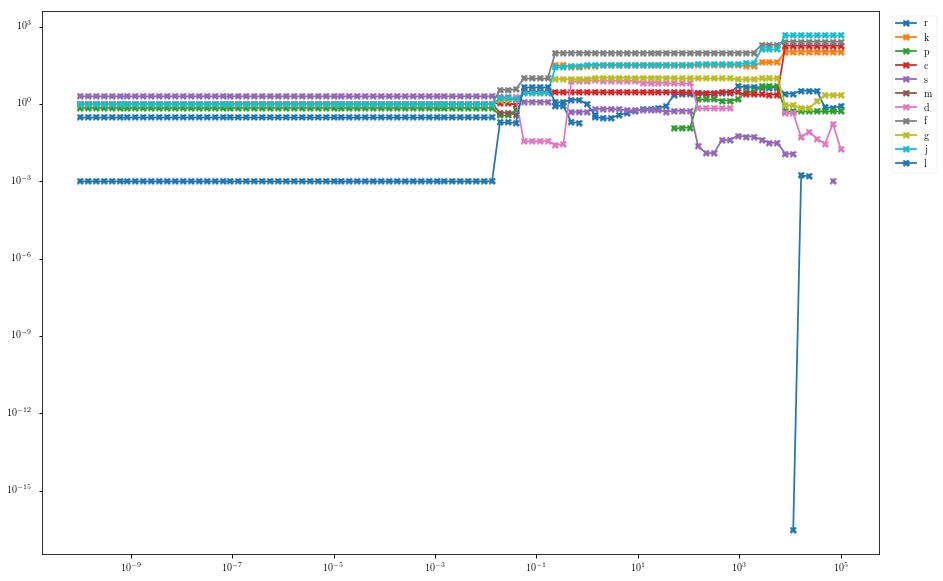

In [11]:
rhos = [float(rho) for rho in solver.solutions.keys()]
vals = [val[0].x for val in solver.solutions.values()]
plt.plot(rhos, vals, 'X-')
plt.legend("rkpcsmdfgjl", loc="best", bbox_to_anchor=(1.01, 1))
plt.xscale("log")
plt.yscale("log", nonposy="mask")

In [12]:
# generate a crude correlation plot

import pandas as pd

results = pd.DataFrame({r"$\rho$": np.log(rhos)})
for idx, name in enumerate("rkpcsmdfgjl"):
    results[name] = [v[idx] for v in vals]
    

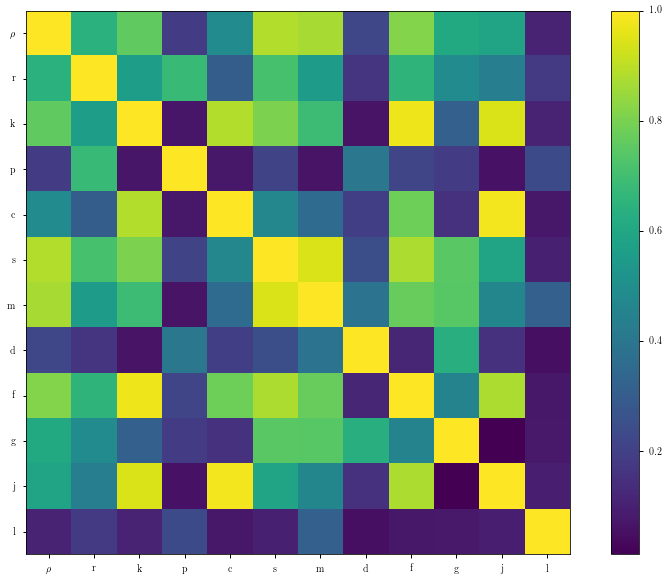

In [13]:
plt.imshow(np.abs(results.corr()))
plt.colorbar()
plt.xticks(range(12), [r"$\rho$"] + list("rkpcsmdfgjl"))
plt.yticks(range(12), [r"$\rho$"] + list("rkpcsmdfgjl"))
plt.grid(False)

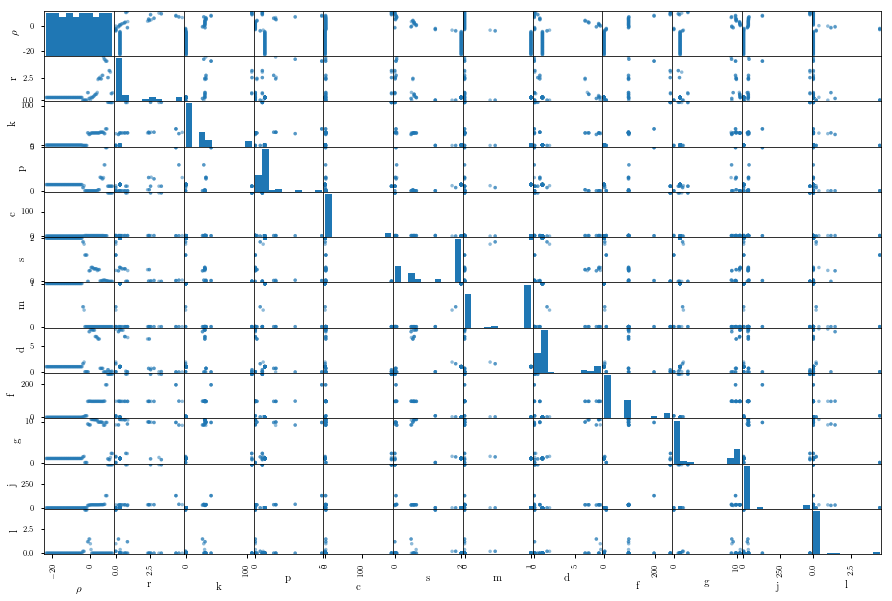

In [14]:
ax = pd.plotting.scatter_matrix(results)
for a in ax.flatten():
    a.grid(False)

Text(0, 0.5, 'Number')

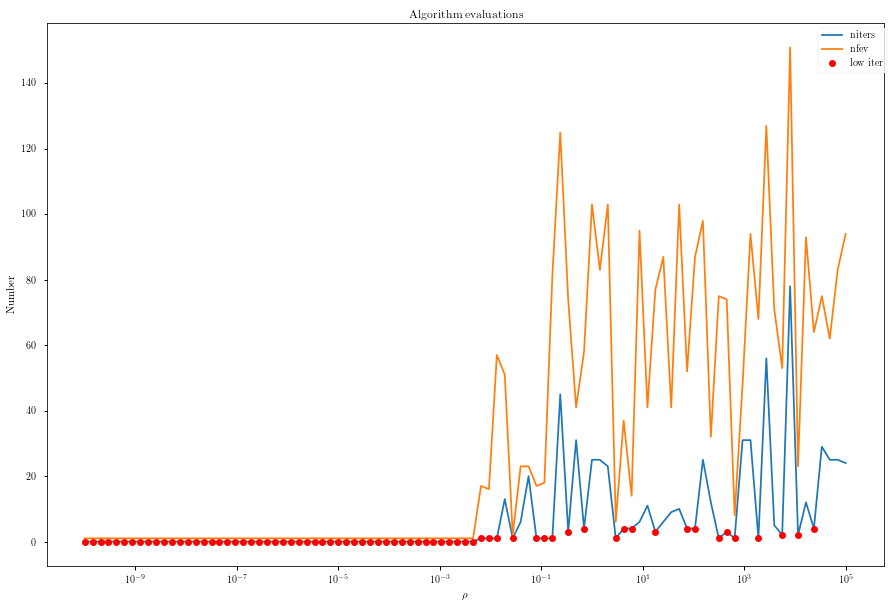

In [15]:
iters_list = np.array([[float(key), value[0].nit] for key, value in solver.solutions.items()])
fevs_list = np.array([[float(key), value[0].nfev] for key, value in solver.solutions.items()])
plt.semilogx(*iters_list.T, *fevs_list.T)

low_iters = np.array([[k,v] for k,v in iters_list if v < 5])
plt.plot(*low_iters.T, 'ro')

plt.legend(["niters", "nfev", "low iter"], 
           loc="best", bbox_to_anchor=(1.01, 1))
plt.title("Algorithm evaluations")
plt.xlabel(r"$\rho$")
plt.ylabel("Number")

In [16]:
def tokey(rho, ps):
    return f"{'y'.join(map(str,ps))}r{rho}"
getx = fitter.ca.Function("getx", [model.ts, *model.cs], model.xs)
    

Text(0.5, 0, 'time, t')

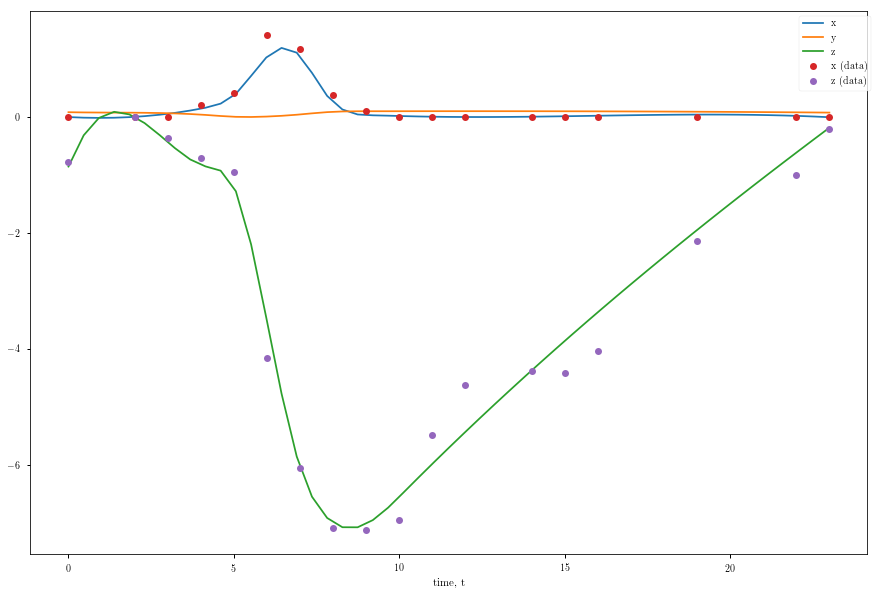

In [27]:
target_rho = 36.51741272548377
c_end = solver.problems[0].cache.results[tokey(target_rho, solver.solutions[str(target_rho)][0].x)].x

xs_end = np.array([np.array(i) for i in getx(model.observation_times, 
                                         *fitter.argsplit(c_end, 
                                                          3)
                                        )])
plt.plot(model.observation_times, np.hstack([xs_end[0], xs_end[1], xs_end[2]]),
         context['datasets'][0]['t'], context['datasets'][0]['x'], 'o',
         context['datasets'][0]['t'], context['datasets'][0]['z'], 'o')
plt.legend(list("xyz") + ["x (data)", "z (data)"], loc="best", bbox_to_anchor=(1.01, 1))
plt.xlabel("time, t")

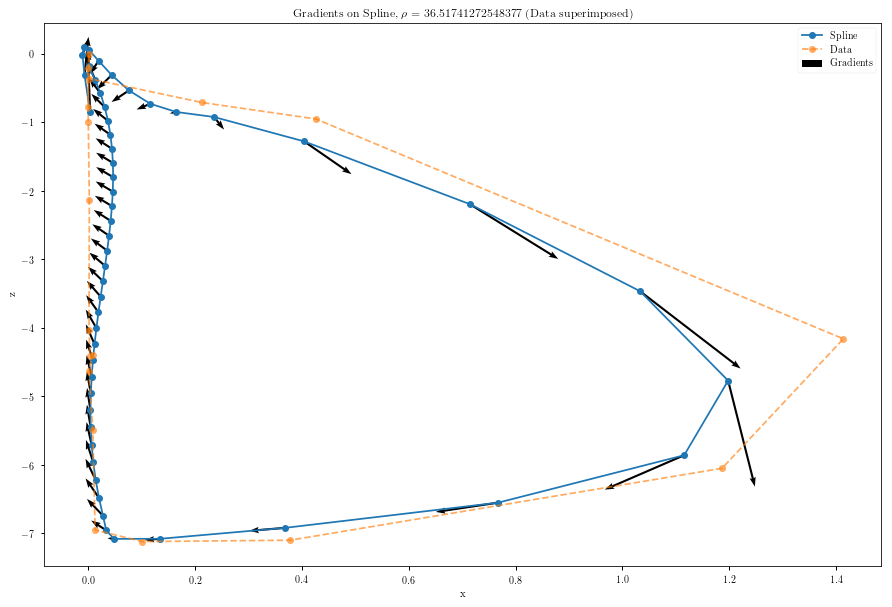

In [28]:
spline_dfield = np.array([context['model'](t, xs_end[:,i], solver.solutions[str(target_rho)][0].x) 
                 for i,t in enumerate(model.observation_times)])

spline_dfield = spline_dfield.reshape(spline_dfield.shape[:2])

plt.plot(xs_end[0], xs_end[2], 'o-')
plt.plot(context['datasets'][0]['x'], context['datasets'][0]['z'], 'o--', alpha=0.65)
plt.quiver(xs_end[0], xs_end[2], spline_dfield[:,0], spline_dfield[:,2], 
           scale=20, angles='xy', headwidth=3, headlength=4.5, headaxislength=4, width=0.0025)
plt.title(f"Gradients on Spline, $\\rho$ = {target_rho} (Data superimposed)")
plt.xlabel("x")
plt.ylabel("z")
plt.legend(["Spline", "Data", "Gradients"])

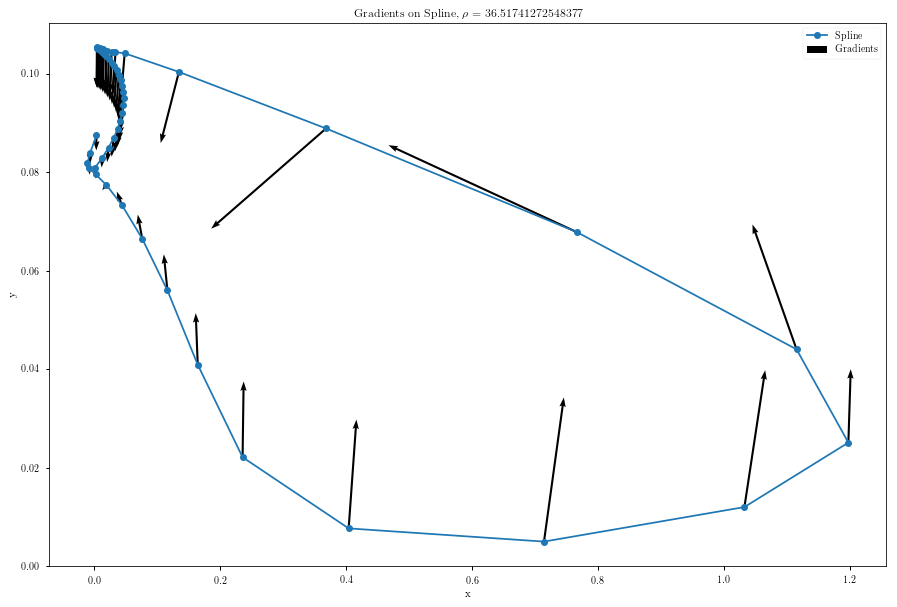

In [29]:
plt.plot(xs_end[0], xs_end[1], 'o-')
plt.quiver(xs_end[0], xs_end[1], spline_dfield[:,0], spline_dfield[:,1], 
           scale=None, angles='xy', headwidth=3, headlength=4.5, headaxislength=4, width=0.0025)
plt.title(f"Gradients on Spline, $\\rho$ = {target_rho}")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(["Spline", "Gradients"])

In [20]:
inner_objective_values = np.array([[r, solver.problems[0].cache.results[tokey(r, v)].fun] for r,v in zip(rhos, vals)])
dfield = np.hstack([np.array(rhos).reshape(-1,1), 
                    ((inner_objective_values - outer_objective_values)[:,1] / rhos).reshape(-1,1)])


Text(0, 0.5, 'Diff Field')

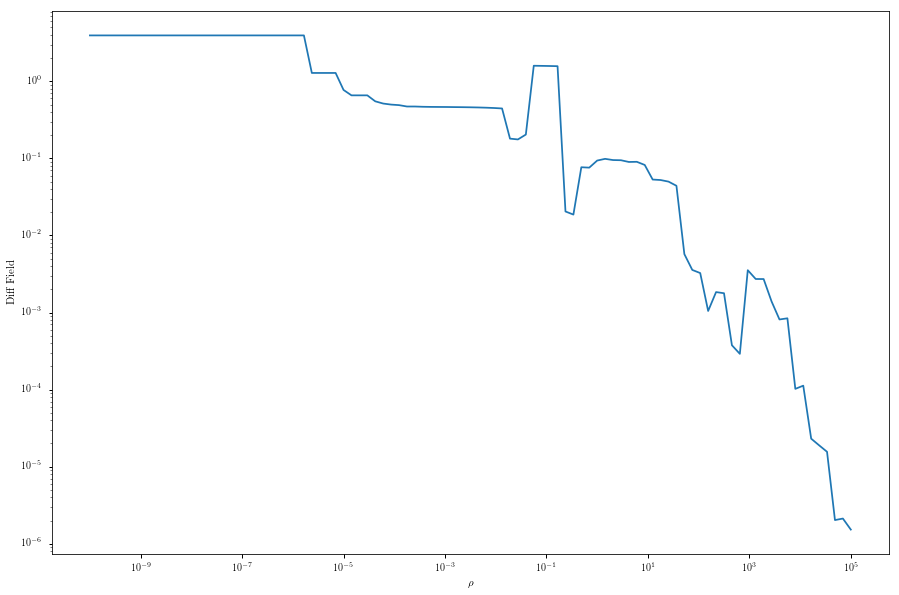

In [21]:
plt.loglog(*dfield.T)
plt.xlabel(r"$\rho$")
plt.ylabel("Diff Field")

Text(0, 0.5, 'Outer Objective (Data Fit)')

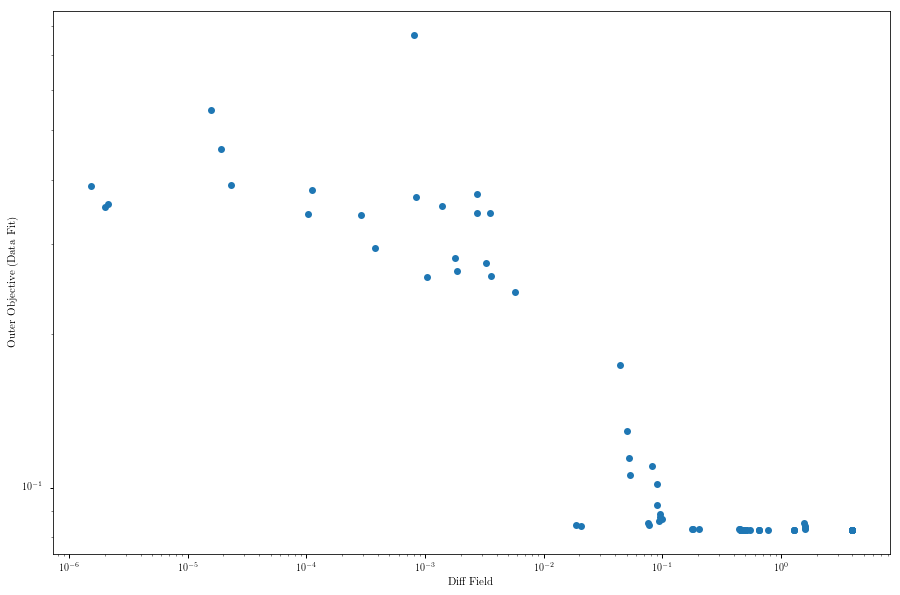

In [22]:
plt.loglog(dfield[:,1] , outer_objective_values[:,1], 'o')
plt.xlabel("Diff Field")
plt.ylabel("Outer Objective (Data Fit)")

In [23]:
rhos

[1e-10,
 1.4330125702369628e-10,
 2.053525026457146e-10,
 2.942727176209282e-10,
 4.2169650342858224e-10,
 6.042963902381328e-10,
 8.659643233600653e-10,
 1.2409377607517196e-09,
 1.7782794100389228e-09,
 2.5482967479793464e-09,
 3.651741272548377e-09,
 5.232991146814947e-09,
 7.498942093324558e-09,
 1.0746078283213174e-08,
 1.539926526059492e-08,
 2.20673406908459e-08,
 3.162277660168379e-08,
 4.5315836376008177e-08,
 6.493816315762114e-08,
 9.30572040929699e-08,
 1.333521432163324e-07,
 1.9109529749704404e-07,
 2.7384196342643614e-07,
 3.924189758484536e-07,
 5.62341325190349e-07,
 8.058421877614818e-07,
 1.1547819846894582e-06,
 1.6548170999431815e-06,
 2.3713737056616552e-06,
 3.3982083289425593e-06,
 4.869675251658631e-06,
 6.978305848598663e-06,
 1e-05,
 1.4330125702369627e-05,
 2.0535250264571462e-05,
 2.9427271762092818e-05,
 4.216965034285822e-05,
 6.042963902381328e-05,
 8.659643233600654e-05,
 0.00012409377607517196,
 0.00017782794100389227,
 0.00025482967479793463,
 0.00036